## Actitracker labeled dataset NN model
This model will use keras to predict activity from sessionized accelerometer data, via the actitracker dataset (http://www.cis.fordham.edu/wisdm/dataset.php). 

### Data Processing

In [1]:
# Feature engineering 
import pandas as pd
import numpy as np
import scipy as sp

# Machine learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

# stats (for AR model)
import statsmodels.api as sm

# Static params
DATA_FOLDER = '/Users/bshur/School/Capstone/Data/'
DATA_FILE = 'WISDM_ar_v1.1/raw_data_fixed.txt'
OUTPUTS = {
            'LR':DATA_FOLDER+'lr_model.dat',
            'MLP':DATA_FOLDER+'mlp_model.h5',
            'XGB':DATA_FOLDER+'xgb.model',
          }


class ActitrackerLR:
    ''' Logistic Regression models
        one for each class
    '''
    @staticmethod
    def train_models(X_train, Y_train, model_params):
        ''' Train models iteratively 
            for each class
        '''
        models = [] 
        for i in xrange(Y_train.shape[1]):
            model = LogisticRegression(**model_params)
            y = Y_train[:,i]
            model.fit(X_train, y)
            models.append(model)
        return models
    
    @staticmethod
    def make_predictions(X_test, models, num_classes=6):
        ''' Make predictions 
            for each class 
        '''
        predictions = np.zeros((X_test.shape[0], num_classes))
        for i, model in enumerate(models):
            p = model.predict_proba(X_test)
            predictions[:,i] = p[:,1]
        return predictions
    
    @staticmethod
    def save_model(models, filename):
        ''' Output model coefficient 
            to file as text
        '''
        with open(filename, 'w') as w:
            for model in models:
                print >>w, list(model.intercept_)+list(model.coef_.ravel())
    
    @staticmethod
    def load_model(filename):
        ''' Read model coefficients 
            from file
        '''
        models = []
        with open(filename, 'r') as r:
            for line in r:
                line = line.strip()
                rawline = eval(line)
                intercept, coef = rawline[0], rawline[1:]
                models.append((np.array(intercept), np.array(coef)))
        return models
    
    @staticmethod
    def getP(X, w, intercept):
        ''' Calculate the probability for 
            an observation given 
            a set of weights and intercept
        '''
        return 1.0/(1+np.exp(-(X.dot(w)+intercept)))


def load_data():
    ''' Load actitracker dataset
        into global 'actitracker' 
        variable
    '''
    global actitracker
    actitracker = pd.read_csv(
        DATA_FOLDER+DATA_FILE ,
        sep=',' ,
        lineterminator=';' ,
        header=None ,
    )
    actitracker.columns = [
        'user' ,
        'activity' ,
        'timestamp' ,
        'x-accel' ,
        'y-accel' ,
        'z-accel' ,
        'NA' ,
    ]
    del actitracker['NA']


def create_sessions():
    ''' Group data by user-session
        in preparation for feature
        engineering
    '''
    global actitracker
    # re-calculate time in seconds
    actitracker['time_seconds'] = actitracker['timestamp']*10e-9

    # sort by user and time 
    actitracker = actitracker.sort_values(by=['user','time_seconds'])

    # create sessions
    session_length = 100
    actitracker['seq'] = xrange(actitracker.shape[0])
    actitracker['session'] = actitracker.\
                               groupby(['user','activity'])['seq'].\
                               apply(lambda x: x%session_length == 0).\
                               fillna(0).cumsum()


def gather_target_vars():
    ''' Gather labels 
        and create Y variable
        for model training
    '''
    global label_lookup
    # get session_labels 
    ohe = OneHotEncoder(sparse=False); le = LabelEncoder()
    labels = actitracker.groupby(['user','session'])['activity'].apply(lambda x: max(x))
    le_labels = le.fit_transform(labels)
    ohe_labels = ohe.fit_transform(le_labels.reshape(-1,1))
    label_lookup = { k: v for k,v in set((i, v) for i,v in np.vstack((le_labels,labels)).T) }
    
    # create target variables
    Y = pd.DataFrame(ohe_labels,index=labels.index)
    return Y


get_label = np.vectorize(lambda x: label_lookup[x])


def fit_ar(x, order):
        ''' Fit AR model at order 
            and return all coefficients
        '''
        try:
            armodel = sm.tsa.AR(x.as_matrix(),missing='drop')
            armodel_results = armodel.fit(maxlag=order,disp=-1)
            return armodel_results.params
        except ValueError:
            return [0]*(order+1)


def feature_engineering():
    ''' Read actitracker pandas 
        object, grouped by user-session,
        and calculate descriptive
        statistics to use as features
        for model training
    '''
    # group by user and session
    accel_cols = ['x-accel','y-accel','z-accel']
    g = actitracker.loc[:,accel_cols+['user','session']].groupby(['user','session'])

    # IQR function
    def iqr(x):
        ''' calculate IQR from array
        '''
        q75, q25 = np.percentile(x, [75,25])
        return q75-q25

    ## calculate model cols 
    # descriptive statistics
    means = g[accel_cols].apply(lambda x: np.mean(x))
    sds = g[accel_cols].apply(lambda x: np.std(x))
    median_1 = g[accel_cols[0]].apply(lambda x: np.median(x))
    median_2 = g[accel_cols[1]].apply(lambda x: np.median(x))
    median_3 = g[accel_cols[2]].apply(lambda x: np.median(x))
    mins = g[accel_cols].apply(lambda x: np.min(x))
    maxs = g[accel_cols].apply(lambda x: np.max(x))
    iqr_1 = g[accel_cols[0]].apply(lambda x: iqr(x))
    iqr_2 = g[accel_cols[1]].apply(lambda x: iqr(x))
    iqr_3 = g[accel_cols[2]].apply(lambda x: iqr(x))
    kurtosis_1 = g[accel_cols[0]].apply(lambda x: sp.stats.kurtosis(x))
    kurtosis_2 = g[accel_cols[1]].apply(lambda x: sp.stats.kurtosis(x))
    kurtosis_3 = g[accel_cols[2]].apply(lambda x: sp.stats.kurtosis(x))
    skew_1 = g[accel_cols[0]].apply(lambda x: sp.stats.skew(x))
    skew_2 = g[accel_cols[1]].apply(lambda x: sp.stats.skew(x))
    skew_3 = g[accel_cols[2]].apply(lambda x: sp.stats.skew(x))
    descriptive_stats = [ means, sds, median_1, median_2, median_3, 
                          mins, maxs, iqr_1, iqr_2, iqr_3, kurtosis_1, 
                          kurtosis_2, kurtosis_3, skew_1, skew_2, skew_3 ]
    
    # avg absolute difference
    avg_absolute_diff_1 = g[accel_cols[0]].apply(lambda x: np.mean(np.absolute(x-np.mean(x))))
    avg_absolute_diff_2 = g[accel_cols[1]].apply(lambda x: np.mean(np.absolute(x-np.mean(x))))
    avg_absolute_diff_3 = g[accel_cols[2]].apply(lambda x: np.mean(np.absolute(x-np.mean(x))))
    avg_absolute_diffs = [ avg_absolute_diff_1, avg_absolute_diff_2, avg_absolute_diff_3 ]
    
    # avg resultant accel
    avg_resultant_accel = g[accel_cols].apply(lambda x: np.mean(np.sqrt(x.iloc[:,0]**2+
                                                                        x.iloc[:,1]**2+
                                                                        x.iloc[:,2]**2)))
    
    # time between peaks
    between_peaks_1 = g[accel_cols[0]].apply(lambda x: np.abs(np.argmax(x)-np.argmin(x)))
    between_peaks_2 = g[accel_cols[1]].apply(lambda x: np.abs(np.argmax(x)-np.argmin(x)))
    between_peaks_3 = g[accel_cols[2]].apply(lambda x: np.abs(np.argmax(x)-np.argmin(x)))
    between_peaks = [ between_peaks_1, between_peaks_2, between_peaks_3 ]
    
    # peak min and max
    peak_1 = g[accel_cols[0]].apply(lambda x: np.argmax(x))
    peak_2 = g[accel_cols[1]].apply(lambda x: np.argmax(x))
    peak_3 = g[accel_cols[2]].apply(lambda x: np.argmax(x))
    peaks = [ peak_1, peak_2, peak_3 ]
    
    # correlation between axis'
    def corr_transform(x):
        pearson_r = sp.stats.pearsonr(x.iloc[:,0],x.iloc[:,1])[0]
        return np.nan_to_num(pearson_r)
    corr_12 = g[accel_cols[:2]].apply(corr_transform)
    corr_13 = g[[accel_cols[0]]+[accel_cols[2]]].apply(corr_transform)
    corr_23 = g[accel_cols[1:]].apply(corr_transform)
    corrs = [ corr_12, corr_13, corr_23 ]
    
    # autoregression
    order = 13
    z1 = g[accel_cols[0]].apply(lambda x: fit_ar(x, order))
    z2 = g[accel_cols[1]].apply(lambda x: fit_ar(x, order))
    z3 = g[accel_cols[2]].apply(lambda x: fit_ar(x, order))
    ar_params = []
    for i in xrange(order):
        for zn in xrange(3):
            eval_str = 'z'+str(zn+1)+'.apply(lambda x: x['+str(i)+'])'
            ar_params.append(eval(eval_str))
    
    # percentiles
    percentiles = []
    for i in range(10,100,10):
        for e in range(1,4):
            eval_str = 'g[accel_cols['+str(e-1)+']].apply(lambda x: sp.percentile(x,'+str(i)+'))'
            percentiles.append(eval(eval_str))

    # concat columns
    X = pd.concat(descriptive_stats+
                  avg_absolute_diffs+
                  [avg_resultant_accel]+
                  between_peaks+
                  peaks+
                  corrs+
                  ar_params+
                  percentiles
                  , axis=1)

    # Scale data
    ss = StandardScaler()
    X = ss.fit_transform(X)
    return X


def lr_evaluate_params(lrmodel, c_values):
    ''' For logistic regression model,
        iterate through regularization
        parameters and return 
        accuracy and log-loss
        in a pandas dataframe object
    '''
    accuracies = []
    log_losses = []
    for c in c_values:
        params = {'C':c,'max_iter':1000,'tol':1e-8}
        models = lrmodel.train_models(X_train, Y_train, params)
        predictions = lrmodel.make_predictions(X_test, models, 6)
        accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(predictions,axis=1))
        ll = log_loss(Y_test, predictions)
        accuracies.append(accuracy)
        log_losses.append(ll)
    evaluation = pd.DataFrame({'C':c_values,'accuracy':accuracies,'log_loss':log_losses})
    print evaluation
    return evaluation



def pred_true(Y_test, predictions):
    pred_category = np.argmax(predictions, axis=1)
    true_category = np.argmax(Y_test, axis=1)
    return pred_category, true_category


def get_accuracy_logloss(Y_test, predictions):
    ''' Take model predictions 
        and true categories and
        return accuracy and log-loss
        
    '''
    pred_category, true_category = pred_true(Y_test, predictions)
    acc = accuracy_score(true_category, pred_category )
    ll = log_loss(Y_test, predictions)
    return acc, ll


def print_accuracy(Y_test, predictions):
    ''' Calculate accuracy and log-loss
        and print out results
    '''
    acc, ll = get_accuracy_logloss(Y_test, predictions)
    print 'Accuracy: {}'.format(acc)
    print 'Log-loss: {}'.format(ll)


def analyze_errors(Y_test, predictions, get_label=get_label):
    ''' Take model predictions 
        and true categories and
        return precision, recall, & F1 score
    '''
    pred_category, true_category = pred_true(Y_test, predictions)
    errors = pred_category != true_category
    true_labels = get_label(true_category)
    base = np.ones(true_labels.shape)
    error_base = pd.DataFrame({'errors':errors,
                      'labels':true_labels,
                      'base':base})
    b = error_base.groupby('labels').sum()
    d = pd.DataFrame((b['errors']/b['base']).sort_values(ascending=False), columns=['Error Rate'])
    p, r, f, s = precision_recall_fscore_support(true_category, pred_category)
    d2 = pd.DataFrame(np.vstack(( label_lookup.values(),p, r, f, s) ).T,
             columns=['labels','Precision','Recall','F1 Score','Support'])
    d2.index=d2['labels']; del d2['labels']
    error_rates = pd.merge(d, d2, how='inner', left_index=True, right_index=True)
    return error_rates.astype('float')


def xgboost_gridsearch(xtrain, xtest, ytrain, ytest, etas, depths, evals, iters=300):
    ''' Run XGBoost model 
        over multiple eta, depth, and
        evaluation metric combinations
    '''
    results = []
    dtrain = xgb.DMatrix( xtrain, label=np.argmax(ytrain, axis=1))
    dtest = xgb.DMatrix( xtest, label=np.argmax(ytest, axis=1))
    evallist  = [(dtest,'eval'), (dtrain,'train')]
    for e in etas:
        for d in depths:
            for ev in evals:
                param = {'bst:max_depth':d, 
                         'bst:eta':e, 
                         'subsample':0.5, 
                         'silent':1, 
                         'num_class':6,
                         'objective':'multi:softprob' }
                param['eval_metric'] = ev
                model = xgb.train(param.items(), dtrain, iters, evallist, verbose_eval=False)
                predictions = model.predict(dtest)
                a, ll = get_accuracy_logloss(ytest, predictions)
                results.append({'eta':e,
                                'depth':d,
                                'eval_metric':ev,
                                'accuracy':a,
                                'error_rate':(1-a),
                                'logloss':ll})
    results_df = pd.DataFrame(results).sort_values(by='error_rate')
    return results_df

In [2]:
# Charts 
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


def lr_param_charts(c_values, accuracies, log_losses):
    ''' Create charts to show
        regularization parameter
        influence on log-loss and accuracy
    '''
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.plot(np.log(c_values), accuracies, 'g')
    plt.title("Change in Accuracy with Decreasing Regularization")
    plt.xlabel("Log of Inv. Regularization Strength (C)")
    plt.ylabel("Accuracy")
    plt.subplot(1,2,2)
    plt.plot(np.log(c_values), log_losses, 'b')
    plt.title("Change in Log-loss with Decreasing Regularization")
    plt.xlabel("Log of Inv. Regularization Strength (C)")
    plt.ylabel("Log-loss")


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    ''' Show confusion matrix plot
    '''
    classes = label_lookup.values()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)


def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    '''Template for generating the plot layout.'''
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax


def cartesian(arrays, out=None):
    ''' Generate a cartesian product of input arrays.
        via http://stackoverflow.com/questions/1208118/
    '''
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out


def xgboost_gridsearch_chart(results_df, 
                             rtype='error_rate',
                             best_eval_metric='mlogloss', 
                             color_start='#172951', 
                             color_end='#3E6CD8',
                             gamma=0.5):
    ''' Create heatmap chart 
        of XGBoost gridsearch results
    '''
    best_eval = results_df['eval_metric'] == best_eval_metric
    rbest = results_df.loc[best_eval,:]
    etaTerms = sorted ( set( rbest.loc[:,'eta'] ))
    depths = sorted ( set( rbest.loc[:,'depth'] ))
    errors_list = []
    for e in etaTerms:
        for d in depths:
            v = rbest.loc[(rbest['eta']==e) & (rbest['depth']==d)][rtype].iloc[0]
            errors_list.append(v)
    
    errors = np.array( errors_list )
    numRows, numCols = len(etaTerms), len(depths)
    errors.shape = (numRows, numCols)
    
    a, b = np.arange(0, numCols, 1), np.arange(0, numRows, 1)
    fig, ax = preparePlot(a, b, figsize=(8, 7),
                          hideLabels=False, gridWidth=0.)
    ax.set_yticklabels(etaTerms), ax.set_xticklabels(depths)
    ax.set_ylabel('eta Parameter'), ax.set_xlabel('Tree Depth')

    colors = LinearSegmentedColormap.from_list('blue', [color_end, color_start], gamma=gamma)
    image = plt.imshow(errors, interpolation='nearest', aspect='auto',
                        cmap = colors)
    ax.set_title('XGBoost Heatmap {}'.format(rtype))
    
    for ab, e in zip(cartesian((a,b)), errors.T.ravel()):
        a,b = ab
        ax.annotate('{}%'.format(round(e*100,2)), xy=(a-0.1,b), textcoords='data', color='white') 
    return fig, ax


def model_comparison_chart(x, y, m, c):
    ''' Show final comparison of models
        in an x-y scatterplot
    '''
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel('Accuracy (%)')
    ax.set_ylabel('Log-Loss')
    # ax.set_title('Overall Model Performance Comparison')
    plt.grid(color='black', linewidth=0.1, linestyle='-')
    for x,y,m,c in zip(x,y,m,c):
        plt.scatter(x*100, y, color=c)
        ax.annotate('{} ( {}, {}% )'.format(m, y, round(x*100,2)), size=15, 
                    xy=(x*100+0.3,y+0.003), textcoords='data', color=c)


def plot_roc_curves(Y_test, predictions, figsize=(6,6)):
    ''' Make an ROC plot 
        for each class prediction
    '''
    colors = ['#2471A3','#1C2833','#17A589','#D68910','#884EA0','#A93226']
    fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1), figsize=figsize)
    ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_title('ROC Curves by Activity Classification')
    plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model

    for i,c in enumerate(colors):
        labelsAndWeights = zip(Y_test[:,i], predictions[:,i])
        labelsAndWeights.sort(key=lambda (x,y):y, reverse=True)
        labelsByWeight = np.array([k for (k, v) in labelsAndWeights])
        length = labelsByWeight.size
        truePositives = labelsByWeight.cumsum()
        numPositive = truePositives[-1]
        falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

        truePositiveRate = truePositives / numPositive
        falsePositiveRate = falsePositives / (length - numPositive)

        # Generate layout and plot data
        plt.plot(falsePositiveRate, truePositiveRate, 
                 color=c, linestyle='-', linewidth=3., 
                 label='{} (area: {})'.format(label_lookup[i],
                                             round(roc_auc_score(Y_test[:,i],predictions[:,i]),3)))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc=4)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Split test and train

In [3]:
load_data()
create_sessions()

In [4]:
Y = gather_target_vars()
X = feature_engineering()
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y.as_matrix(), 
                                                    test_size=0.33, 
                                                    random_state=22)

### Baseline Model

In [5]:
predictions = np.zeros(Y_test.shape)
for i in xrange(predictions.shape[0]):
    predictions[i,:] = np.sum(Y_test, axis=0) / np.sum(Y_test)

In [6]:
print_accuracy(Y_test, predictions)

Accuracy: 0.393839383938
Log-loss: 1.47770495241


In [7]:
analyze_errors(Y_test, predictions)

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Error Rate,Precision,Recall,F1 Score,Support
labels,,,,,
Downstairs,1,0.000000,0,0.000000,296
Jogging,1,0.000000,0,0.000000,1127
Sitting,1,0.000000,0,0.000000,193
Standing,1,0.000000,0,0.000000,154
Upstairs,1,0.000000,0,0.000000,434
Walking,0,0.393839,1,0.565114,1432


/Library/Python/2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


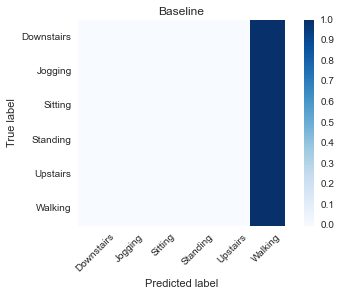

In [8]:
pred_category, true_category = pred_true(Y_test, predictions)
cm = confusion_matrix(true_category, pred_category)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Baseline')

### LR Model

In [9]:
lrmodel = ActitrackerLR()

#### Evaluate model params

In [10]:
c_values = [ 1e-5, 1e-3, 1e-1, 1.0, 10.0, 1e2, 1e4, 1e6 ]
evaluation = lr_evaluate_params(lrmodel, c_values)

               C  accuracy  log_loss
0        0.00001  0.710121  1.688573
1        0.00100  0.806381  1.004044
2        0.10000  0.890539  0.416674
3        1.00000  0.902090  0.374536
4       10.00000  0.904565  0.373300
5      100.00000  0.905941  0.391000
6    10000.00000  0.900990  0.460588
7  1000000.00000  0.900715  0.503286


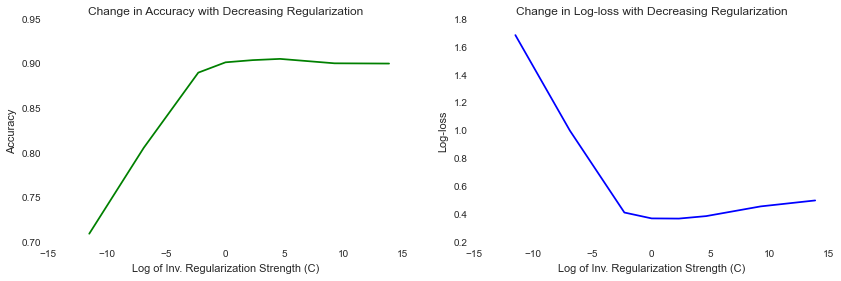

In [11]:
lr_param_charts(evaluation['C'],evaluation['accuracy'],evaluation['log_loss'])

#### Train final model

In [12]:
params = {'C':10.0,'max_iter':1000,'tol':1e-8,'solver':'lbfgs'}
models = lrmodel.train_models(X_train, Y_train, params)

#### Test prediction accuracy

In [13]:
predictions = lrmodel.make_predictions(X_test, models, 6)

In [14]:
print_accuracy(Y_test, predictions)

Accuracy: 0.904840484048
Log-loss: 0.376794502581


#### Analyze errors

In [15]:
analyze_errors(Y_test, predictions)

,Error Rate,Precision,Recall,F1 Score,Support
labels,,,,,
Downstairs,0.398649,0.741667,0.601351,0.664179,296
Jogging,0.023070,0.964943,0.976930,0.970899,1127
Sitting,0.067358,0.967742,0.932642,0.949868,193
Standing,0.051948,0.929936,0.948052,0.938907,154
Upstairs,0.239631,0.791367,0.760369,0.775558,434
Walking,0.053771,0.906355,0.946229,0.925863,1432


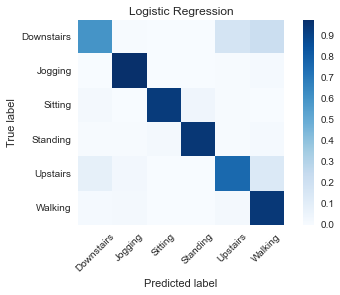

In [16]:
pred_category, true_category = pred_true(Y_test, predictions)
cm = confusion_matrix(true_category, pred_category)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Logistic Regression')

#### ROC 

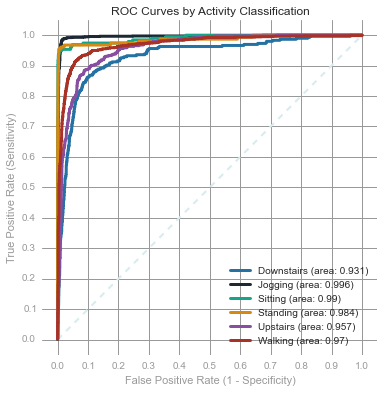

In [17]:
plot_roc_curves(Y_test, predictions)

#### Output model to file

In [18]:
lrmodel.save_model(models, OUTPUTS['LR'])

### MLP Neural Network Model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2, activity_l2
# from keras.utils.visualize_util import plot

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


#### Compile model

In [20]:
model = Sequential()

indim = X.shape[1]
model.add(Dense(512*6, input_dim=indim, activation='relu', 
                W_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(512*12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512*6, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

#### Execute model

In [21]:
model.fit(X_train, Y_train,
          nb_epoch=20,
          batch_size=20)

Epoch 1/20
7382/7382 [==============================] - 120s - loss: 0.8142 - acc: 0.7330   
Epoch 2/20
7382/7382 [==============================] - 120s - loss: 0.4586 - acc: 0.8490   
Epoch 3/20
7382/7382 [==============================] - 120s - loss: 0.3625 - acc: 0.8819   
Epoch 4/20
7382/7382 [==============================] - 120s - loss: 0.3160 - acc: 0.8984   
Epoch 5/20
7382/7382 [==============================] - 120s - loss: 0.2818 - acc: 0.9111   
Epoch 6/20
7382/7382 [==============================] - 119s - loss: 0.2534 - acc: 0.9195   
Epoch 7/20
7382/7382 [==============================] - 118s - loss: 0.2267 - acc: 0.9236   
Epoch 8/20
7382/7382 [==============================] - 118s - loss: 0.2182 - acc: 0.9275   
Epoch 9/20
7382/7382 [==============================] - 118s - loss: 0.2051 - acc: 0.9334   
Epoch 10/20
7382/7382 [==============================] - 118s - loss: 0.1864 - acc: 0.9403   
Epoch 11/20
7382/7382 [==============================] - 118s - loss:

In [22]:
predictions = model.predict(X_test)
print_accuracy(Y_test, predictions)

Accuracy: 0.952145214521
Log-loss: 0.213360291793


In [23]:
analyze_errors(Y_test, predictions)

,Error Rate,Precision,Recall,F1 Score,Support
labels,,,,,
Downstairs,0.192568,0.865942,0.807432,0.835664,296
Jogging,0.012422,0.979754,0.987578,0.983650,1127
Sitting,0.046632,0.963351,0.953368,0.958333,193
Standing,0.045455,0.936306,0.954545,0.945338,154
Upstairs,0.078341,0.836820,0.921659,0.877193,434
Walking,0.037011,0.986409,0.962989,0.974558,1432


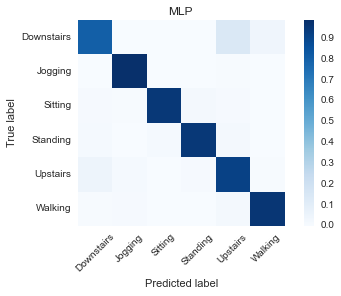

In [24]:
pred_category, true_category = pred_true(Y_test, predictions)
cm = confusion_matrix(true_category, pred_category)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'MLP')

plot(model, to_file='mlp_model.png')

#### ROC

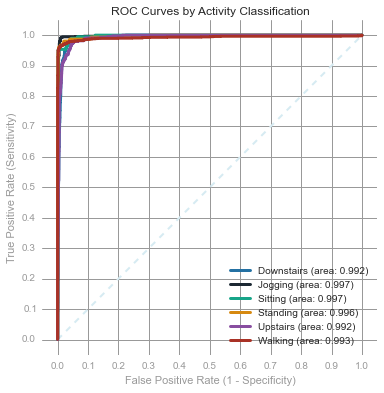

In [25]:
plot_roc_curves(Y_test, predictions)

#### Save Model

model.save(OUTPUTS['MLP']) 

### XGBoost 

In [26]:
import xgboost as xgb

#### Evaluate Model Params

In [27]:
etas = [ 0.05, 0.1, 0.25, 0.4 ]
depths = [ 10, 15, 18, 20, 22 ]
evals = ['mlogloss'] #merror
results_df = xgboost_gridsearch(X_train, 
                                X_test, 
                                Y_train, 
                                Y_test, 
                                etas, 
                                depths, 
                                evals, 
                                iters=500)

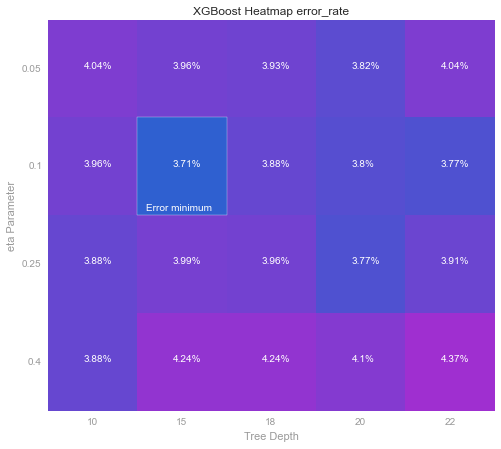

In [28]:
fig, ax = xgboost_gridsearch_chart(results_df, rtype='error_rate', gamma=0.5, 
                                   color_start='#9F2FD0', color_end='#2F60D0')
ax.add_patch(patches.Rectangle((0.5,.495), 1, 1, fill=False, color='white'))
ax.annotate('Error minimum', xy=(0.5,1), xytext=(0.6, 1.45), color='white')

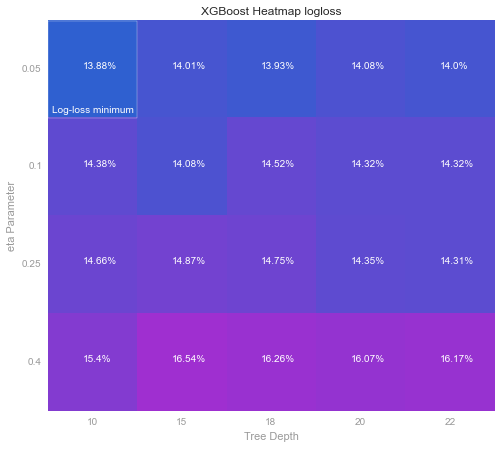

In [29]:
fig, ax = xgboost_gridsearch_chart(results_df, rtype='logloss', gamma=0.5, 
                                   color_start='#9F2FD0', color_end='#2F60D0')
ax.add_patch(patches.Rectangle((-0.5,-.495), 1, 1, fill=False, color='white'))
ax.annotate('Log-loss minimum', xy=(0.5,1), xytext=(-0.45, 0.45), color='white')

#### Compile model

In [30]:
dtrain = xgb.DMatrix( X_train, label=np.argmax(Y_train, axis=1))
dtest = xgb.DMatrix( X_test, label=np.argmax(Y_test, axis=1))
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'bst:max_depth':15, 
         'bst:eta':0.1, 
         'subsample':0.5, 
         'silent':1, 
         'num_class':6,
         'objective':'multi:softprob' }
param['eval_metric'] = 'mlogloss'
model = xgb.train(param.items(), dtrain, 500, evallist, verbose_eval=False)

#### Test accuracy

In [31]:
predictions = model.predict(dtest)
pred_category = np.argmax(predictions, axis=1)
true_category = np.argmax(Y_test, axis=1)
print_accuracy(Y_test, predictions)

Accuracy: 0.962871287129
Log-loss: 0.140804911293


#### Analyze errors

In [32]:
analyze_errors(Y_test, predictions)

,Error Rate,Precision,Recall,F1 Score,Support
labels,,,,,
Downstairs,0.141892,0.927007,0.858108,0.891228,296
Jogging,0.013310,0.982332,0.986690,0.984506,1127
Sitting,0.046632,0.989247,0.953368,0.970976,193
Standing,0.038961,0.961039,0.961039,0.961039,154
Upstairs,0.062212,0.879050,0.937788,0.907469,434
Walking,0.025140,0.978276,0.974860,0.976565,1432


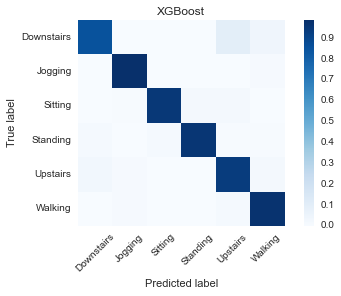

In [33]:
pred_category, true_category = pred_true(Y_test, predictions)
cm = confusion_matrix(true_category, pred_category)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'XGBoost')

#### ROC 

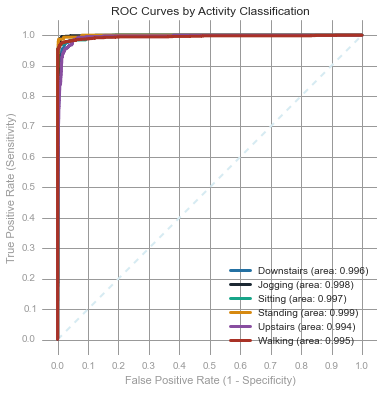

In [34]:
plot_roc_curves(Y_test, predictions)

#### Save Model

In [35]:
model.save_model(OUTPUTS['XGB'])

### Summary of  Models

#### Overall Performance

<table border="1" class="dataframe" align="left">
         <thead>
           <tr style="text-align: right;">
             <th></th>
             <th>Accuracy</th>
             <th>Log-Loss</th>
           </tr>
         </thead>
         <tbody>
           <tr>
             <th>XGBoost</th>
             <td>96.3%</td>
             <td>0.141</td>
           </tr>
           <tr>
             <th>MLP Neural Net</th>
             <td>95.2%</td>
             <td>0.213</td>
           </tr>
           <tr>
             <th>Logistic Regression</th>
             <td>90.5%</td>
             <td>0.377</td>
           </tr>
         </tbody>
       </table>

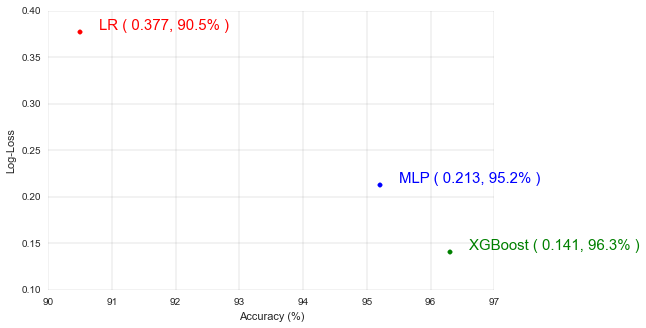

In [37]:
accuracies,loglosses,models,colors = [0.963,0.952,0.905],[0.141,0.213,0.377],\
            ['XGBoost','MLP','LR'],['g','b','r']
model_comparison_chart(accuracies, loglosses, models, colors)

#### Error Rates

<table border="1" class="dataframe" align="left">
         <thead>
           <tr style="text-align: right;">
             <th></th>
             <th>XGBoost</th>
             <th>MLP</th>
             <th>LR</th>
           </tr>
         </thead>
         <tbody>
           <tr>
             <th>Downstairs</th>
             <td>14.2%</td>
             <td>19.3%</td>
             <td>40.0%</td>
           </tr>
           <tr>
             <th>Upstairs</th>
             <td>6.2%</td>
             <td>7.8%</td>
             <td>24.0%</td>
           </tr>
           <tr>
             <th>Sitting</th>
             <td>4.7%</td>
             <td>4.7%</td>
             <td>6.7%</td>
           </tr>
           <tr>
             <th>Standing</th>
             <td>3.9%</td>
             <td>4.5%</td>
             <td>5.2%</td>
           </tr>
           <tr>
             <th>Walking</th>
             <td>2.5%</td>
             <td>3.7%</td>
             <td>5.4%</td>
           </tr>
           <tr>
             <th>Jogging</th>
             <td>1.3%</td>
             <td>1.2%</td>
             <td>2.3%</td>
           </tr>
         </tbody>
       </table>